



# <div align="center">  Image Classifier using Transfer learning

* Transfer learning in image classification is based on the idea that if a model is trained on a sufficiently large and diverse dataset, it can develop a broad understanding of visual patterns and features.

* Instead of starting from scratch every time we want to train a new model for a specific task, we can leverage the knowledge and feature representations learned by pre-trained models.

* This approach saves time and computational resources since we don't have to train a new model from the ground up.

* It's like building on top of existing knowledge rather than reinventing the wheel, allowing us to achieve good performance even with smaller datasets or specific tasks.

Let's start building a cat and dog image classifier using transfer learning with tensorflow.

**Importing  Libraries**






In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
print(os.path)

<module 'posixpath' from '/usr/lib/python3.10/posixpath.py'>


**Downloading data**

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 [==============================] - 1s 0us/step


In [5]:
train_files = os.listdir(train_dir)
print("Training directory files:", train_files)

Training directory files: ['dogs', 'cats']


**Create train dataset and validation dataset from train and validation directory**

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Splitting train and validation dataset**


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

**Data Augmentation**

In [8]:
data_augmentation = tf.keras.Sequential([
  # A preprocessing layer which randomly flips images during training.
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # A preprocessing layer which randomly rotates images during training.
  tf.keras.layers.RandomRotation(0.2),
])


**Looking at the pixel values of the first image in the train_dataset**

In [9]:
for images, labels in train_dataset:
    # Print the pixel values of the first image in the batch
    print("Pixel values of the first image:")
    print(images[0].numpy())
    break

Pixel values of the first image:
[[[216.35938  215.35938  213.35938 ]
  [219.11911  216.60037  215.10661 ]
  [221.16084  217.       215.67831 ]
  ...
  [176.64853  164.64853  114.64854 ]
  [177.30312  165.30312  115.303116]
  [177.13658  165.13658  115.13658 ]]

 [[219.35974  216.64412  214.07225 ]
  [220.94487  217.28952  214.93439 ]
  [222.50497  217.57187  214.22314 ]
  ...
  [174.10185  162.10185  112.10185 ]
  [175.92188  163.92188  113.92187 ]
  [176.9035   164.9035   114.903496]]

 [[222.7454   218.90625  215.58458 ]
  [222.48311  218.44745  214.02373 ]
  [225.4126   218.8042   213.20312 ]
  ...
  [172.35938  160.35938  110.359375]
  [175.01122  163.01122  113.011215]
  [176.83125  164.83125  114.83125 ]]

 ...

 [[110.76084  116.85459   80.72979 ]
  [114.55312  120.623146  85.6125  ]
  [111.671875 117.71875   83.71875 ]
  ...
  [118.4458   120.4458    96.4458  ]
  [121.03495  123.03495   99.03495 ]
  [122.       124.       100.      ]]

 [[112.50625  120.50625   81.69926 ]
  [1

finding the minimum and maximum value of pixels in train dataset ; found the range to be [0,255]

In [10]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')  # Initialize to positive infinity
max_pixel_value = float('-inf')  # Initialize to negative infinity

# Assuming you already have train_dataset defined
# Iterate over the dataset to access individual images
for images, labels in train_dataset:
    # Compute minimum and maximum pixel values in the current batch
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)

    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Convert TensorFlow tensors to Python scalars
min_pixel_value = min_pixel_value.numpy()
max_pixel_value = max_pixel_value.numpy()

# Print the lower and upper range of pixel values
print("Lower range of pixel values:", min_pixel_value)
print("Upper range of pixel values:", max_pixel_value)

Lower range of pixel values: 0.0
Upper range of pixel values: 255.0


**Looking at the dimensions of image and label**

In [11]:
for images, labels in train_dataset:
    # Print the shape of the batch of images and labels
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break  # Stop after examining the first batch

Batch of images shape: (32, 160, 160, 3)
Batch of labels shape: (32,)


**Taking a look at the data after data augmemtation**

In [12]:
data_augmentation = tf.keras.Sequential([
  # A preprocessing layer which randomly flips images during training.
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # A preprocessing layer which randomly rotates images during training.
  tf.keras.layers.RandomRotation(0.2),
])

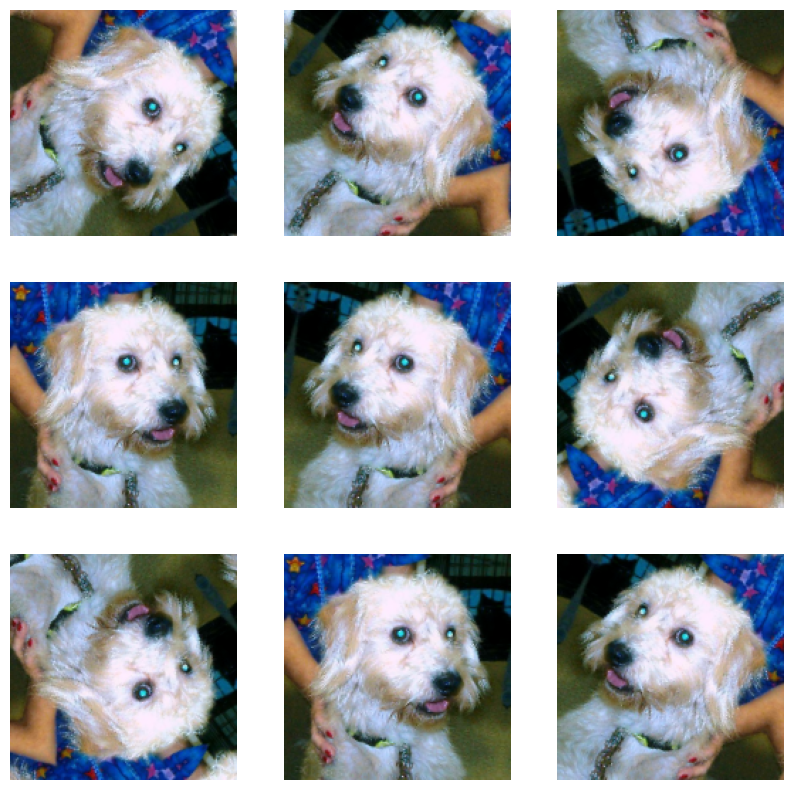

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[10]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**Pre-processing input**

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Creating base model from pre-trained MobileNet V2**

 We will pass training images to base model and get features output by base model.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
# 32 images, since our batch_size is 32
print(feature_batch.shape)

9406464/9406464 [==============================] - 1s 0us/step
(32, 5, 5, 1280)


**Freezing the pre-trained model**


When utilizing the base model for feature extraction, it's crucial to freeze the convolutional base before compiling and training the model. Freezing, achieved by setting layer.trainable = False, ensures that the weights within a specific layer remain unchanged throughout the training process. Considering MobileNet V2 comprises numerous layers, setting the trainable flag for the entire model to False effectively freezes all these layers.

In [16]:
base_model.trainable = False

**Extracting features**


To get predictions from the features, we use a GlobalAveragePooling2D layer. This layer takes all the information in the features and condenses it into a single vector for each image. It does this by averaging the values across all the spatial dimensions, resulting in a 1280-element vector for each image.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# (32, 5, 5, 1280) -> (32, 1280)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Chaining the layers**

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

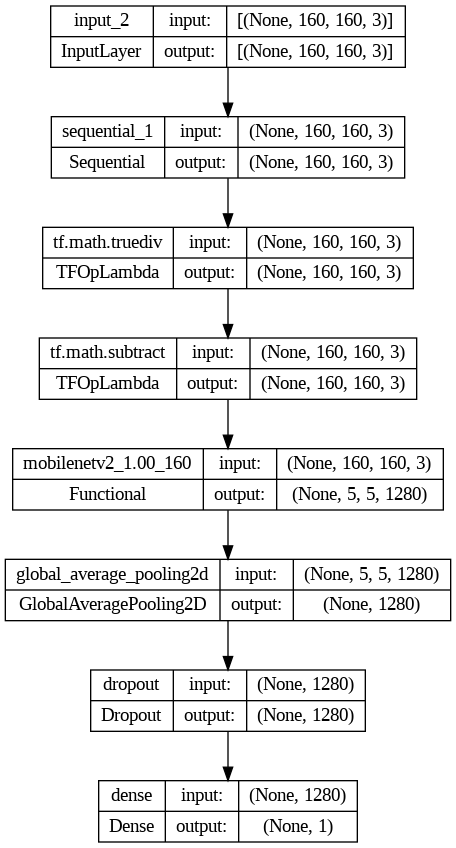

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Compiling the model**

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the model**

In [22]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 82s 1s/step - loss: 0.8450 - accuracy: 0.4975 - val_loss: 0.6763 - val_accuracy: 0.6015
Epoch 2/10
63/63 [==============================] - 73s 1s/step - loss: 0.6585 - accuracy: 0.6115 - val_loss: 0.5180 - val_accuracy: 0.7178
Epoch 3/10
63/63 [==============================] - 76s 1s/step - loss: 0.5477 - accuracy: 0.7000 - val_loss: 0.4192 - val_accuracy: 0.7884
Epoch 4/10
63/63 [==============================] - 96s 2s/step - loss: 0.4706 - accuracy: 0.7645 - val_loss: 0.3511 - val_accuracy: 0.8292
Epoch 5/10
63/63 [==============================] - 79s 1s/step - loss: 0.4312 - accuracy: 0.7810 - val_loss: 0.2939 - val_accuracy: 0.8614
Epoch 6/10
63/63 [==============================] - 110s 2s/step - loss: 0.4054 - accuracy: 0.8110 - val_loss: 0.2536 - val_accuracy: 0.8911
Epoch 7/10
63/63 [==============================] - 116s 2s/step - loss: 0.3710 - accuracy: 0.8185 - val_loss: 0.2367 - val_accuracy: 0.8985
Epoch 8/10
63/63 [

In [23]:
class_names = sorted(os.listdir(validation_dir))
print(class_names)

['cats', 'dogs']


making predictions on a batch of validation_dataset

Predictions:
 [1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1]
Labels:
 [1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1]


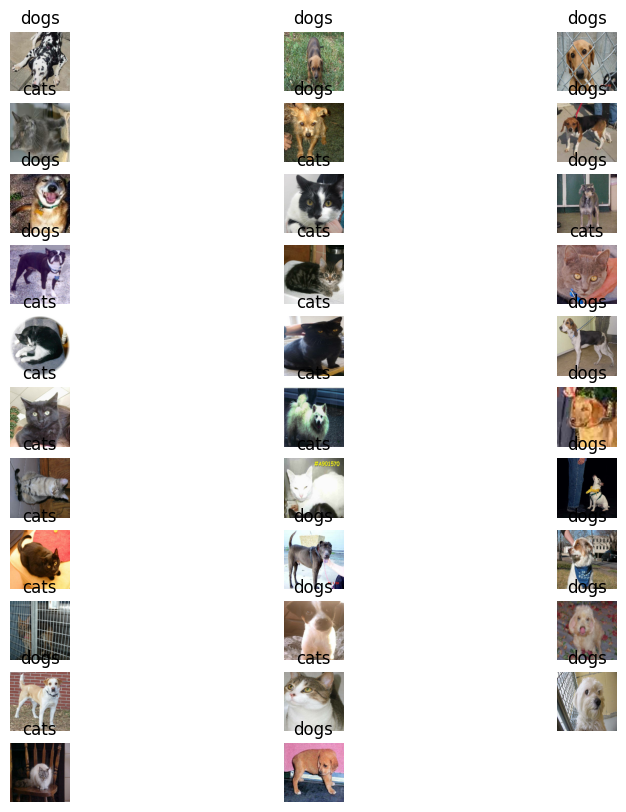

In [24]:
import math
num_images = len(image_batch)
num_rows = math.ceil(num_images / 3)
num_cols = min(num_images, 3)


# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(len(image_batch)):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

looking at first image from a batch of validation data set

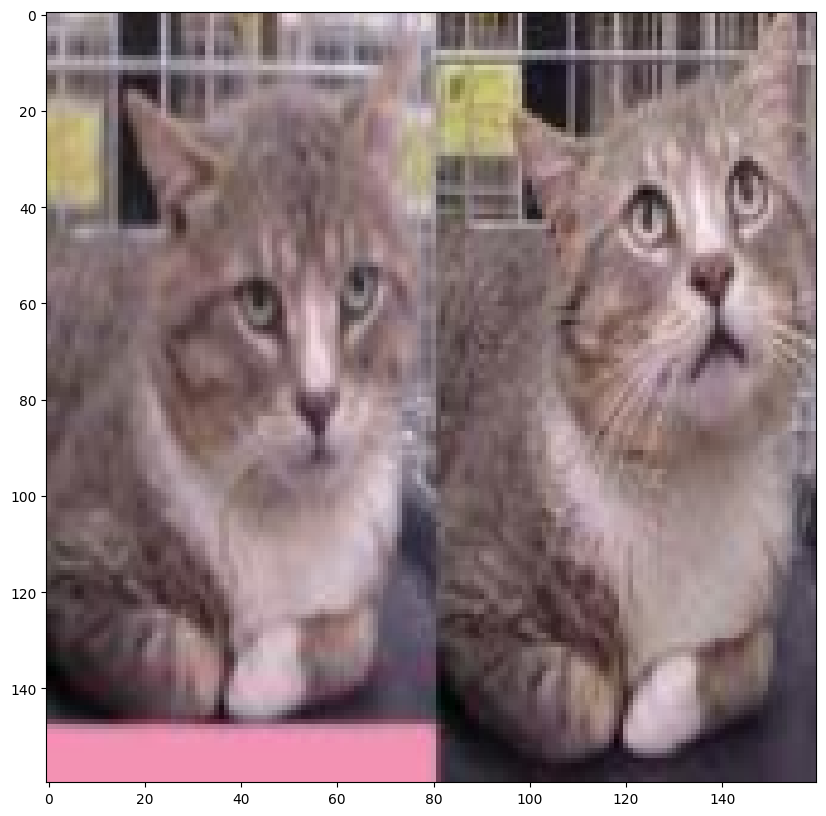

In [25]:
for image, _ in validation_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  plt.imshow(first_image/255)
  plt.axis('on')

making prediction on the first image of batch 5, in validation dataset



1/1 [==============================] - 2s 2s/step
Predictions:
 [0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0]
Labels:
 tf.Tensor([0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0], shape=(32,), dtype=int32)


(-0.5, 159.5, 159.5, -0.5)

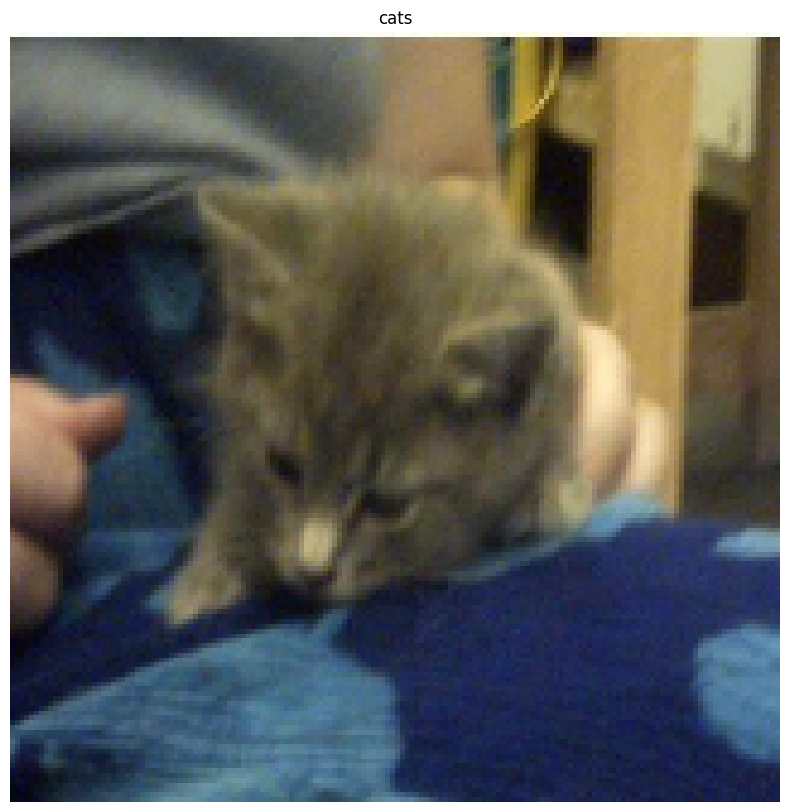

In [26]:
image,label = next(iter(validation_dataset.take(5)))

prediction = model.predict(image).flatten()
# Apply a sigmoid since our model returns logits
prediction = tf.nn.sigmoid(prediction)
prediction = tf.where(prediction < 0.5, 0, 1)
print('Predictions:\n', prediction.numpy())
print('Labels:\n', label)
plt.figure(figsize=(10, 10))
plt.imshow(image[0]/255)
plt.title(class_names[prediction[0]])
plt.axis("off")

confusion matrix

1/1 [==============================] - 1s 1s/step


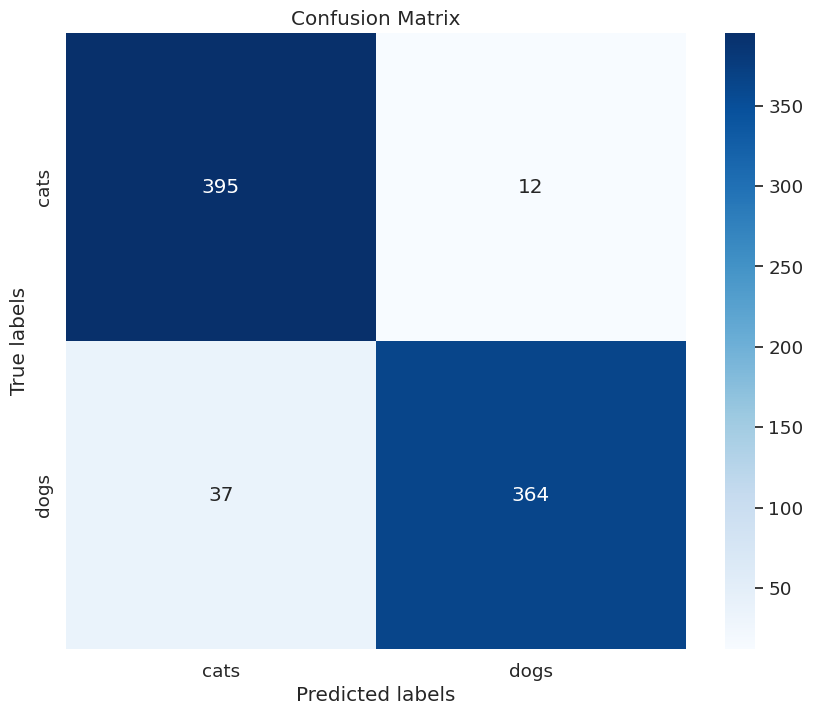

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming `validation_dataset` is your validation dataset

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset to get true and predicted labels
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    predicted_labels.extend(predictions.numpy())

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get class names (assuming class_names contains the names of the classes)
class_names = ['cats','dogs']  # Replace with your actual class names

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Predictions:
 [0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]
Labels:
 [0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0]


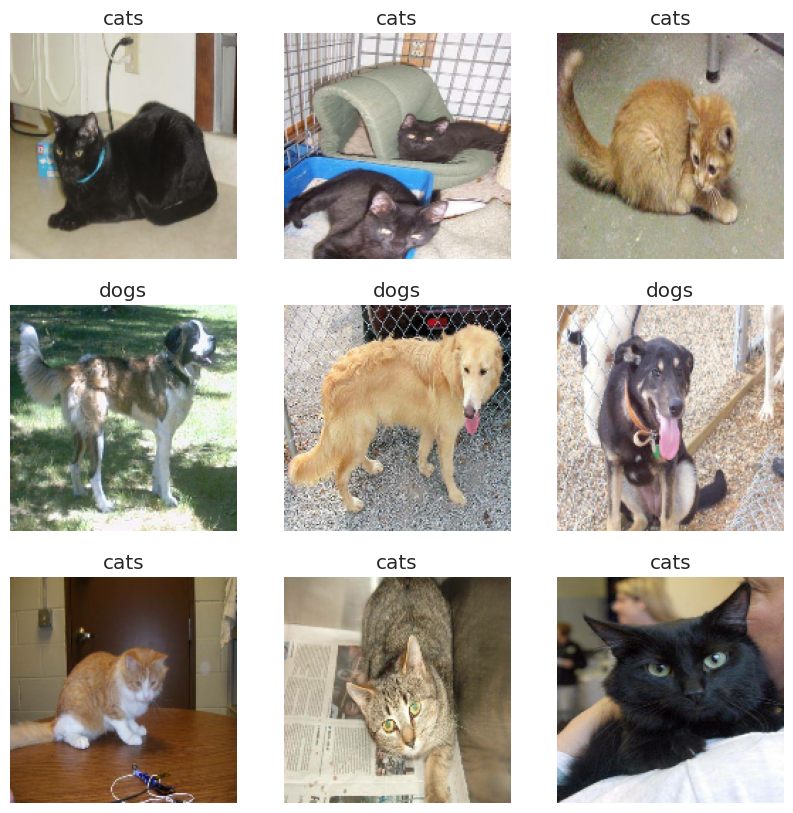

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

**Learning Curves**

It can be observed that validation metrics outperform training metrics, it's primarily due to the influence of BatchNormalization and Dropout layers during training. These layers impact accuracy during training but are deactivated when computing validation loss.

Additionally, the discrepancy can be partially attributed to the way metrics are reported. While training metrics provide an average over an epoch, validation metrics are assessed after the epoch, leading them to observe a model that has trained slightly longer.

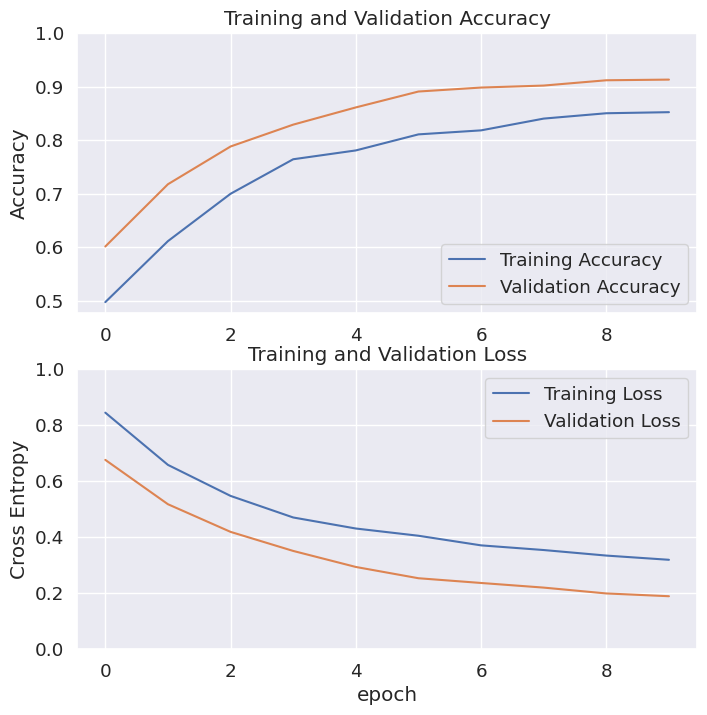

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()